# Análise Dilma
### Analisando sentenças relacionadas a Dilma

### Setup

**Atenção!**

- Todo o setup dos notebooks sobre a campanha eleitoral foram feitos no google colab, ou seja, não recomendamos que rode os scripts em um ambiente jupyter comum.
- Tenha cuidado ao selecionar o arquivo quando for rodar os scripts, nesse repositório será disponibilizado apenas uma cópia mais leve do verdadeiro arquivo que foi usado na análise.

In [229]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u402-ga-2ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Importando bibliotecas





In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark import SparkContext, SparkConf

from unicodedata import normalize
import nltk
from functools import reduce
nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Inicializando Spark

In [231]:
spark = SparkSession.builder \
    .appName('ElectionCampaignTweetsAnalysis') \
    .getOrCreate()
spark

Essa etapa só consegue ser executada em ambiente do google colab

In [232]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [233]:
def extract_word_udf(word):
  @udf(returnType=BooleanType())
  def extract_word(text):
      text_sem_acento_e_pontuacao = re.sub(r'[^a-zA-Z0-9 ]', ' ', normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII'))
      return bool(re.search(rf'\b{word}\b', text_sem_acento_e_pontuacao, re.IGNORECASE))
  return extract_word

In [241]:
# Aqui fico alterando entre uma cópia mais leve além da mais pesada                     "debate-tweets_c2.tsv/debate-tweets.tsv"
df = spark.read.option('header', 'false').option('delimiter', '\t').csv('./drive/MyDrive/debate-tweets.tsv') \
    .withColumnRenamed('_c1', 'text').select('text')

Aqui posso trocar minha analise entre `aecio` e `dilma`

In [242]:
# aecio/dilma
WORD = 'dilma'

In [243]:
df = df.withColumn("contains_" + WORD, extract_word_udf(WORD)(df["text"]))
df = df.filter(df[("contains_" + WORD)] == True).select('text')

Limpeza e formatação de dados

In [244]:
import unicodedata

def cleaner(df, column_name):
    @udf(returnType=StringType())
    def remove_accents(input_str):
        return ''.join(c for c in unicodedata.normalize('NFKD', input_str) if not unicodedata.combining(c))

    df = df.withColumn(column_name + "_cleaned", remove_accents(col(column_name)))
    df = df.withColumn(column_name + "_cleaned", regexp_replace(col(column_name + "_cleaned"), "[^a-zA-Z0-9 ]", ""))
    return df

def get_words(df, input_col, output_col):
    return Tokenizer(inputCol=input_col, outputCol=output_col).transform(df).filter(df[input_col] != '')

def remove_stop_words(df, input_col, output_col):
  stopwordList = nltk.corpus.stopwords.words('portuguese')
  return StopWordsRemover(inputCol=input_col, outputCol=output_col, stopWords=stopwordList).transform(df)

In [245]:
new_df = remove_stop_words(
    get_words(
        cleaner(
            df,
            'text'
        ),
        'text_cleaned',
        'text_tokens'
    ),
    'text_tokens',
    'text_tokens_cleaned'
)
new_df = new_df.filter(size(new_df["text_tokens_cleaned"]) > 0)

Com os dados mais limpos, fazemos n-gramas

In [246]:
def create_expressions(df, ngram_range, input_col, output_col = 'expressions'):
    expressions = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        expressions.append(
            NGram(n=n, inputCol=input_col, outputCol=output_col) \
                .transform(df)
        )
    return reduce(lambda df1, df2: df1.union(df2), expressions)

In [247]:
newer_df = create_expressions(new_df, (3, 5), 'text_tokens_cleaned')
expressions = newer_df.select('expressions').filter(size(newer_df['expressions']) > 0)

new_expressions = expressions.withColumn("sentences", explode("expressions")) \
  .select("sentences") \
  .filter(col("sentences").isNotNull()) \
  .dropna()

top_results = new_expressions.groupBy("sentences") \
  .count().orderBy(col("count").desc()) \
  .limit(20)

pandas_top_results = top_results.toPandas()
pandas_top_results

,sentences,count
0,,785
1,,550
2,,427
3,dilma passando mal,198
4,dilma passou mal,147
5,aprovado ate dilma,97
6,dilma,92
7,aecio aprovado ate dilma,89
8,aecio aprovado ate,89
9,dilma so fala,84


Como tivemos problemas com alguns caracteres/palavras (que não aparecem e também não são strings vazias), vamos remover eles da lista do top na mão

In [255]:
df_unique = pandas_top_results.drop([0, 1, 2, 6, 11, 17]).reset_index(drop=True).head(10)
df_unique

,sentences,count
0,dilma passando mal,198
1,dilma passou mal,147
2,aprovado ate dilma,97
3,aecio aprovado ate dilma,89
4,aecio aprovado ate,89
5,dilma so fala,84
6,dilma passa mal,82
7,vai votar dilma,79
8,dilma x aecio,73
9,ta passando mal,72


In [256]:
import seaborn as sns

def make_bar_plot(style, palette, figsize, x, y, data, title, xlabel, ylabel, fontsize):
    sns.set_style(style)
    sns.set_palette(palette)

    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y, data=data)

    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.show()

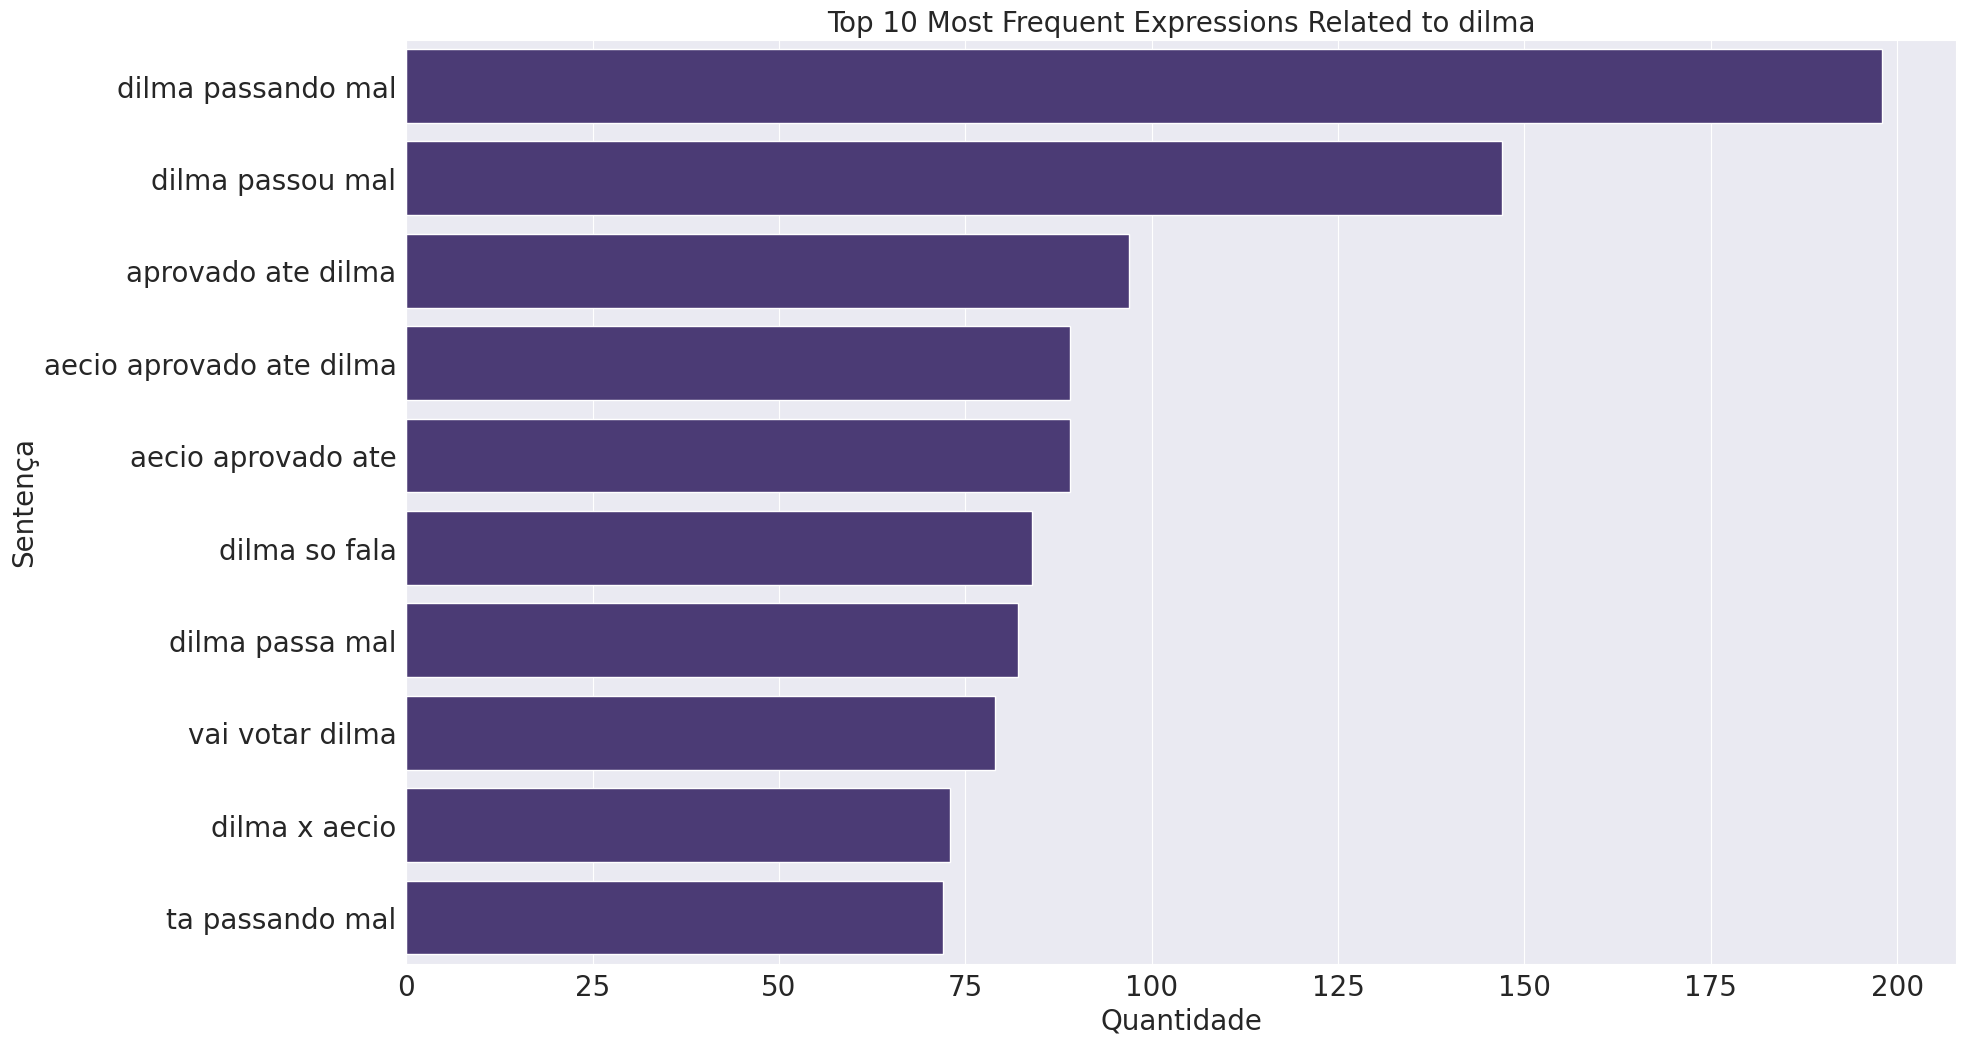

In [259]:
make_bar_plot("darkgrid", "viridis", (20,12), 'count', 'sentences', df_unique, 'Top 10 Most Frequent Expressions Related to ' + WORD, 'Quantidade', 'Sentença', 20)

In [ ]:
spark.stop()